<a href="https://colab.research.google.com/github/djbell01/563-DawsonBell/blob/main/MC_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [326]:
import numpy as np
import matplotlib.pyplot as plt
import copy

In [381]:
class Particle():
  def __init__(self,position):
    self.position = np.array(position)

class System():
  def __init__(self,N,L,sigma):
    self.N = N
    self.L = L
    self.sigma = sigma

    self.particles = []
    for i in range(self.N):
      position = np.random.uniform(-self.L/2,self.L/2,3)
      self.particles.append(Particle(position))

    # Check and resolve overlaps
    for i in range(self.N):
        overlap = True
        while overlap:
            overlap = False
            for j in range(i):  # Only check previous particles
                distance = self.minimum_image_distance(self.particles[i].position, self.particles[j].position)
                if distance < self.sigma:  # Overlap detected
                    self.particles[i].position = np.random.uniform(0, self.L, 3)
                    overlap = True
                    break  # Restart check for this particle

    self.energy = self.calculate_energy()

  def minimum_image_distance(self,pos1,pos2):
    diff_vector = pos1 - pos2
    diff_vector = (diff_vector+(self.L/2))%self.L-(self.L/2)
    return np.linalg.norm(diff_vector)

  def calculate_energy(self):
    energy = 0
    for i in range(len(self.particles)):
      for j in range(len(self.particles)):
        if i < j:
          distance = self.minimum_image_distance(self.particles[i].position,self.particles[j].position)
          epsilon = 1.0
          energy += 4*epsilon*((self.sigma/distance)**12 - (self.sigma/distance)**6)
    self.energy = energy
    return energy

class Dynamics():
  def __init__(self,N,L,sigma,nsteps,temperature):
    self.system = System(N,L,sigma)
    self.nsteps = nsteps
    self.T = temperature
    self.energies = []
    self.per_particle_energies = []

  def run_dynamics(self):
    self.accepted = 0
    self.rejected = 0
    for i in range(self.nsteps):
      new_system = copy.deepcopy(self.system)
      rand_particle_index = np.random.randint(0,new_system.N)
      random_movement = np.random.uniform(-new_system.sigma,new_system.sigma)
      random_direction = np.random.randint(3) # 0=x, 1=y, 2=z
      new_system.particles[rand_particle_index].position[random_direction] = new_system.particles[rand_particle_index].position[random_direction] + random_movement
      if np.abs(new_system.particles[rand_particle_index].position[random_direction]) >= new_system.L/2:
        new_system.particles[rand_particle_index].position[random_direction] = (new_system.particles[rand_particle_index].position[random_direction]+(new_system.L/2))%new_system.L-(new_system.L/2)


      new_energy = new_system.calculate_energy()
      delta_E = new_energy - self.system.energy
      if delta_E < 0:
        self.system = new_system
        self.energies.append(new_energy)
        self.accepted += 1
      elif delta_E >= 0:
        boltzmann_factor = np.exp(-delta_E/self.T)
        rand = np.random.random()
        if rand <= boltzmann_factor:
          self.system = new_system
          self.energies.append(new_energy)
          self.accepted += 1
        elif rand > boltzmann_factor:
          self.energies.append(self.system.energy)
          self.rejected += 1
    self.per_particle_energies = np.array(self.energies)/self.system.N

  def plot_energy(self):
    fig = plt.figure(figsize = (15,5))
    ax1 = fig.add_subplot(1,2,1)
    ax1.plot(self.energies)
    ax1.set_xlabel('Simulation Step')
    ax1.set_ylabel('System Energy ($\epsilon$)')
    ax2 = fig.add_subplot(1,2,2)
    ax2.plot(self.per_particle_energies)
    ax2.set_xlabel('Simulation Step')
    ax2.set_ylabel('Per-Particle Energy ($\epsilon$)')



In [378]:
d = Dynamics(10,10,1,1000,1)
d.run_dynamics()


(-5.0, 5.0)

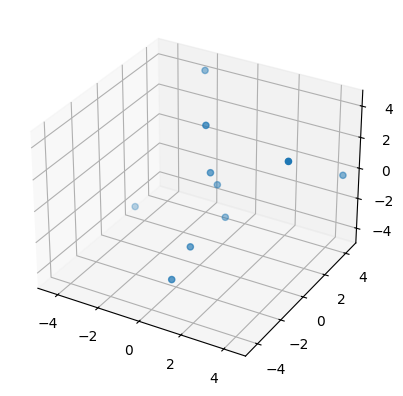

In [379]:
positions = [d.system.particles[i].position for i in range(len(d.system.particles))]
positions = np.array(positions)
x,y,z = positions.T

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x,y,z)
ax.set_xlim(-5,5)
ax.set_ylim(-5,5)
ax.set_zlim(-5,5)

Text(0, 0.5, 'Per-Particle Energy ($\\epsilon$)')

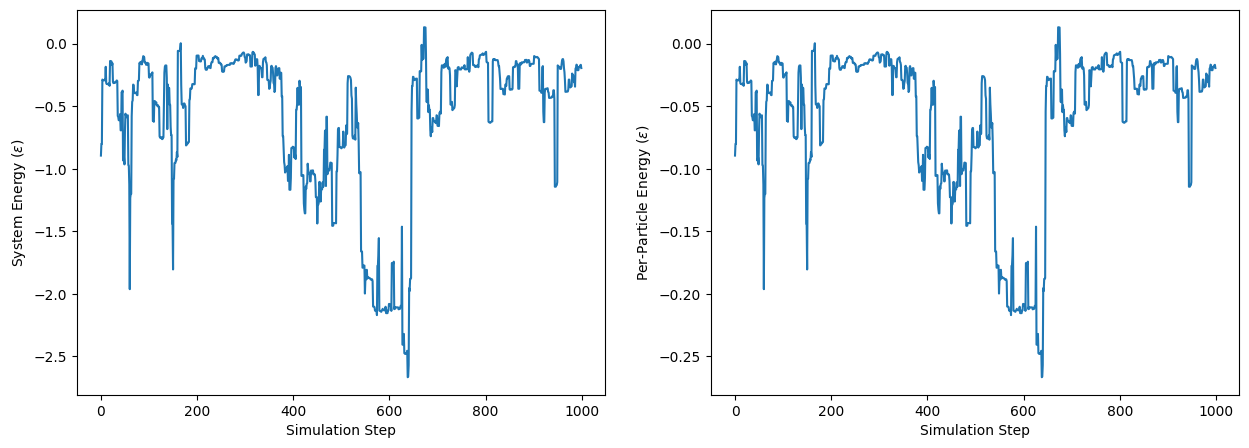

In [380]:
fig = plt.figure(figsize = (15,5))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(d.energies)
ax1.set_xlabel('Simulation Step')
ax1.set_ylabel('System Energy ($\epsilon$)')
ax2 = fig.add_subplot(1,2,2)
ax2.plot(d.per_particle_energies)
ax2.set_xlabel('Simulation Step')
ax2.set_ylabel('Per-Particle Energy ($\epsilon$)')

# 3. Characterize Performance

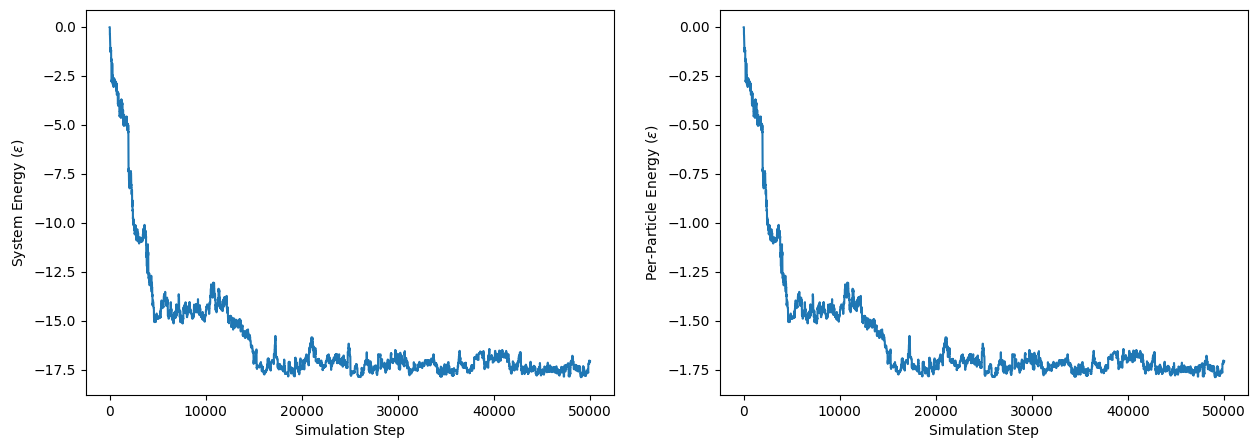

In [397]:
# System with particle density (N/V) of 0.01 sigma^-3
# equilibrate in about 15,000 steps at T = 0.1

temp_test = Dynamics(10,10,1,50000,0.1)
temp_test.run_dynamics()
temp_test.plot_energy()

51.85757350921631


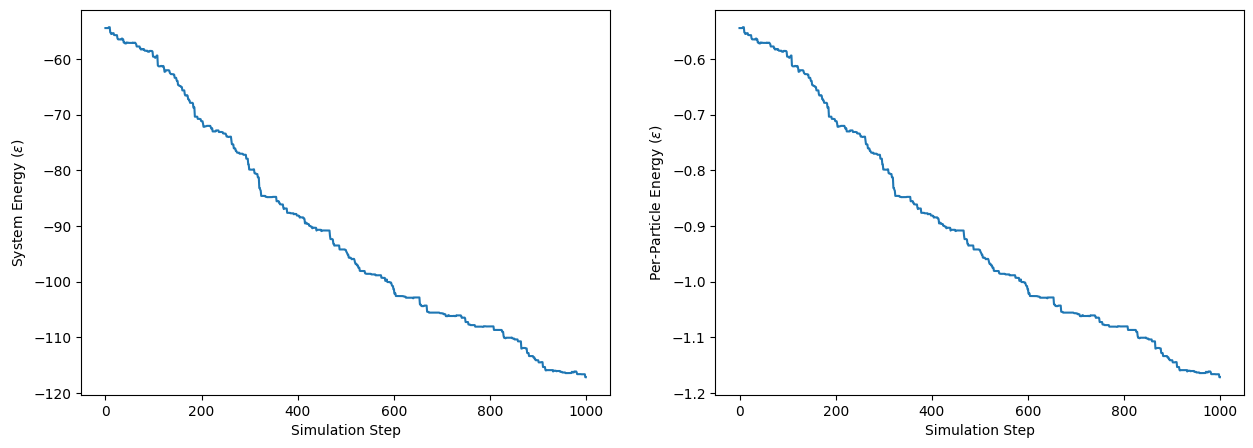

In [399]:
# I can't feasibly test higher densities with this system size.
# A system of 100 particles, which only achieves N/V = 0.1 sigma^-3,
# takes almost 1 minute to run for 1000 particles.

import time
t0 = time.time()
time_test = Dynamics(100,10,1,1000,0.1)
time_test.run_dynamics()
time_test.plot_energy()
t1 = time.time()
print(t1-t0)

265.1411497592926


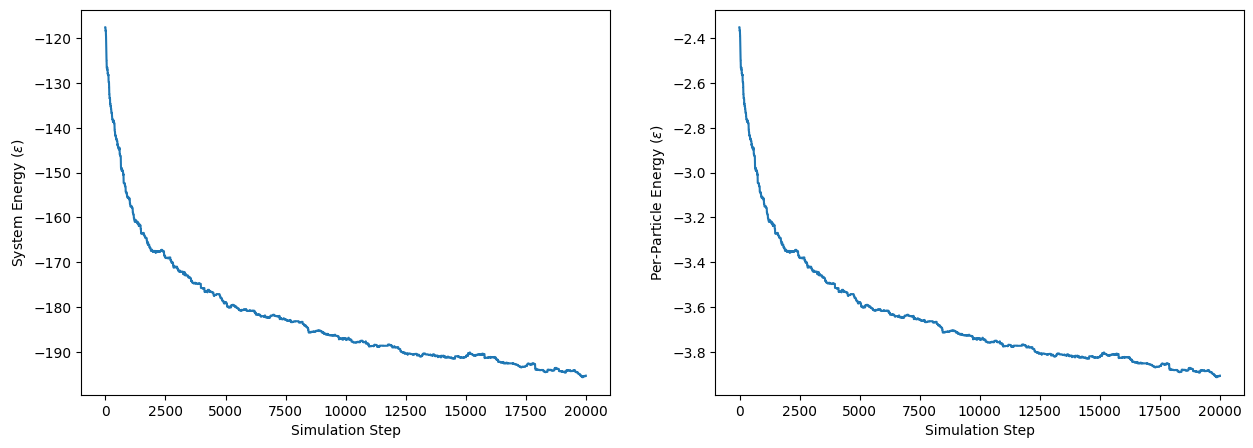

In [410]:
# This is right near the limit of what is feasible.
# A system with N/V = 50/125 = 0.4 nears equilibration
# after about 20,000 steps. It take around 4m 30s to run.

t0 = time.time()
dens_test = Dynamics(50,5,1,20000,0.1)
dens_test.run_dynamics()
dens_test.plot_energy()
t1 = time.time()
print(t1-t0)

In [405]:
# Now that I know what the particle density limits are, it's interesting to
# see how systems of different size but similar N/V value compare to one another.

size_test1 = Dynamics(26,4,1,20000,0.1) # N/V = 0.40625 sigma^-3
size_test1.run_dynamics()

size_test2 = Dynamics(11,3,1,20000,0.1) # N/V = 0.40741 sigma^-3
size_test2.run_dynamics()

size_test3 = Dynamics(3,2,1,20000,0.1) # N/V = 0.375 sigma^3
size_test3.run_dynamics()

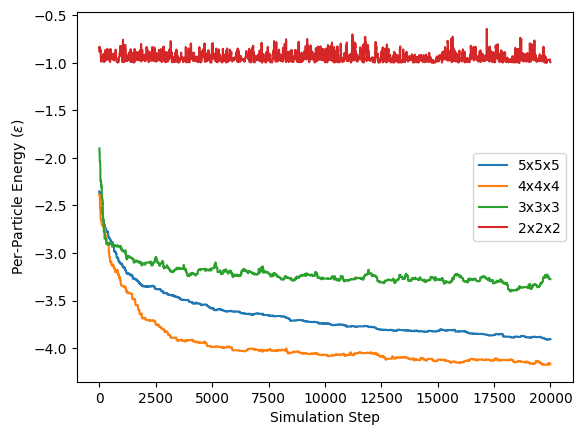

In [413]:
# The 4x4x4 system strikes the best balance between physical realism
# and computational efficiency.

plt.plot(dens_test.per_particle_energies, label='5x5x5')
plt.plot(size_test1.per_particle_energies, label='4x4x4')
plt.plot(size_test2.per_particle_energies, label='3x3x3')
plt.plot(size_test3.per_particle_energies, label='2x2x2')
plt.xlabel('Simulation Step')
plt.ylabel('Per-Particle Energy ($\epsilon$)')
plt.legend()